In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from tag_handler import *

In [4]:
from cvs_reader import *
from vocab import *
from dataframe_creator import create_seperate_columns, create_listed_columns

# Get dataframe with tags and category_id columns
csvpath = '/content/CAvideos.csv'
tab_dataframe = load_tags_and_labels_df(csvpath)
max_of_tags = 25

vocab = get_tags_vocab(tab_dataframe['tags'])
tab_dataframe = create_seperate_columns(tab_dataframe, max_of_tags, 'tags')

tab_dataframe.head()

,category_id,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24
0,10,Eminem,Walk,On,Water,Aftermath/Shady/Interscope,Rap,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
1,23,plush,bad unboxing,unboxing,fan mail,idubbbztv,idubbbztv2,things,best,packages,plushies,chontent chop,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
2,23,racist superman,rudy,mancuso,king,bach,racist,superman,love,rudy mancuso poo bear black white official mus...,iphone x by pineapple,lelepons,hannahstocking,rudymancuso,inanna,anwar,sarkis,shots,shotsstudios,alesso,anitta,brazil,Getting My Driver's License,Lele Pons,notags,notags
3,24,ryan,higa,higatv,nigahiga,i dare you,idy,rhpc,dares,no truth,comments,comedy,funny,stupid,fail,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
4,10,edsheeran,ed sheeran,acoustic,live,cover,official,remix,official video,lyrics,session,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags


In [5]:
# Convert vocab to dictionary
voc_di = get_tags_vocab_as_dict(vocab)

# Mapping tags to indexes in vocab
for col in tab_dataframe.columns:
    if col == 'category_id':
      continue
    tab_dataframe[col] = tab_dataframe[col].map(voc_di)

tab_dataframe.fillna(0, inplace = True) 
tab_dataframe.head()

,category_id,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24
0,10,97444,1417,59942,142412,717,5932,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,23,77800,39440,81155,67484,145159,121384,101591,106888,89205,104828,10477,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,23,141956,17488,67611,59909,102198,1195,75604,72919,100968,104305,63312,53382,85838,48617,77478,75940,12749,143342,140896,60926,104434,28424,92633,-1,-1
3,24,125746,131794,36796,109816,69423,34595,80778,124192,139562,84807,142233,95764,88501,142617,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,10,49530,130244,37828,38639,108229,53805,72962,149723,46303,115729,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [0]:
future_df = []
col_row_dict = {}
# We only use 1/4 of the dataset!
first_half_df = tab_dataframe[:10000]

In [0]:
for i in range(0, 10000):
    for col in first_half_df.columns:
        if col == 'category_id':
            col_row_dict.update({'category_id':first_half_df[col][i]})
        else:
            col_row_dict.update({'tag_{}'.format(first_half_df[col][i]):1.0})
    future_df.append(col_row_dict)
    col_row_dict = {}

In [8]:
final_dataframe = pd.DataFrame(future_df)
final_dataframe.fillna(0.0, inplace = True)
from input_generator import load_dataset_with_lables
final_dataframe.head()

,category_id,tag_-1,tag_0,tag_1,tag_10000,tag_100005,tag_100008,tag_100013,tag_100017,tag_100018,tag_10002,tag_100021,tag_100025,tag_100026,tag_100027,tag_100028,tag_100039,tag_100041,tag_100042,tag_100048,tag_100055,tag_100058,tag_100059,tag_10007,tag_100082,tag_100084,tag_100088,tag_100089,tag_100096,tag_100098,tag_100099,tag_100107,tag_100111,tag_100112,tag_100123,tag_100124,tag_100133,tag_100135,tag_100141,tag_100143,...,tag_99841,tag_99852,tag_99856,tag_99857,tag_99860,tag_99867,tag_99871,tag_99875,tag_99876,tag_99877,tag_99880,tag_99881,tag_99887,tag_99892,tag_99898,tag_99899,tag_99901,tag_99906,tag_99909,tag_99912,tag_99913,tag_99917,tag_99918,tag_99923,tag_99926,tag_99935,tag_99936,tag_99938,tag_99941,tag_99951,tag_99967,tag_99970,tag_99973,tag_9998,tag_99981,tag_99983,tag_99986,tag_9999,tag_99993,tag_99997
0,10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,23,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
from input_generator import load_dataset_with_lables


# Create train,validation and test examples from tags and labels dataframe
(train_ds, train_lb), (val_ds, val_lb), (test_ds, test_lb) = load_dataset_with_lables(final_dataframe, 'category_id')

In [10]:
train_ds.values

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [11]:
train_lb.values

array([22, 22, 26, ..., 24, 22, 20])

In [30]:
hidden = 128
model = tf.keras.Sequential([
    layers.Flatten(),
    layers.Dense(hidden,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(hidden,activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(2*hidden,activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(44, activation='softmax')])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              )

history = model.fit(train_ds.values, train_lb.values,
                    batch_size=32,
                    epochs=6,
                    validation_data=(val_ds.values, val_lb.values))


Train on 6000 samples, validate on 2000 samples
Epoch 1/6
6000/6000 [==============================] - 15s 3ms/sample - loss: 2.4082 - acc: 0.3547 - val_loss: 1.4339 - val_acc: 0.6665
Epoch 2/6
6000/6000 [==============================] - 15s 2ms/sample - loss: 1.1687 - acc: 0.7182 - val_loss: 0.8825 - val_acc: 0.8080
Epoch 3/6
6000/6000 [==============================] - 15s 2ms/sample - loss: 0.7142 - acc: 0.8568 - val_loss: 0.7397 - val_acc: 0.8395
Epoch 4/6
6000/6000 [==============================] - 14s 2ms/sample - loss: 0.5602 - acc: 0.8898 - val_loss: 0.6796 - val_acc: 0.8520
Epoch 5/6
6000/6000 [==============================] - 14s 2ms/sample - loss: 0.4827 - acc: 0.9098 - val_loss: 0.6383 - val_acc: 0.8760
Epoch 6/6
6000/6000 [==============================] - 15s 2ms/sample - loss: 0.4230 - acc: 0.9212 - val_loss: 0.6078 - val_acc: 0.8770


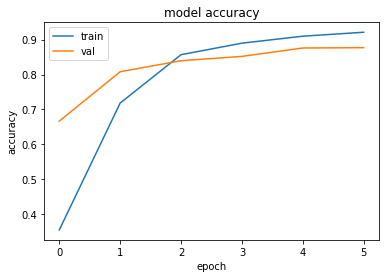

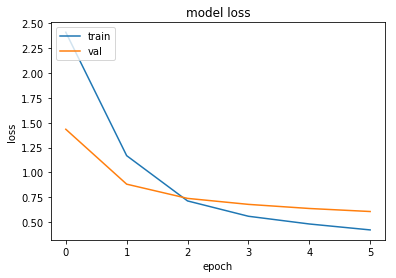

In [31]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
results = model.evaluate(test_ds, test_lb)

print(results)

2000/2000 [==============================] - 2s 902us/sample - loss: 0.7201 - acc: 0.8480
[0.7200772824287415, 0.848]


In [0]:
predictions = model.predict(test_ds)
cat_tit_dict = get_category_title_dict('/content/CA_category_id.json')


In [0]:
def one_hot_to_index(one_hot):
  i_tags = []
  for i, b in enumerate(one_hot):
    if b == 1.0:
      i_tags.append(i)      
  return i_tags

def index_to_tag(i_tags):
  w_tags = []
  reversed_vocab_dict = {i: vo for vo, i in voc_di.items()}
  for index in i_tags:
    w_tags.append(reversed_vocab_dict[index])
  return w_tags
 

In [35]:
for i in range(30, 40):
  one_hot = one_hot_to_index(test_ds.values[i])
  tags_i = index_to_tag(one_hot)
  print(tags_i)
  print('predict:{}'.format(cat_tit_dict[str(np.argmax(predictions[i]))]))
  print('true label:{}'.format(cat_tit_dict[str(test_lb.values[i])]))

['bmhh tap 338', 'shot glass challenge', 'its christmas day bro lyrics', 'Sin Pijama new song', 'boss lil pump', 'Scotty Sire', 'Pre-Sale', 'pelicans vs warriors game 4', '油管', 'Pen Cap Holes', 'craziest']
predict:Entertainment
true label:Entertainment
['bmhh tap 338', '年代传奇电视剧', 'AskMKBHD', 'Route 66']
predict:Entertainment
true label:Entertainment
['nigerian', 'Big idea', 'best actress nominees', 'backyard experiments', 'funny statement', 'correctional camp', 'harry and meghan wedding', 'infrared', 'honest photographers', 'team miley', 'Top Fives', 'drama queens and drama kings', 'Spicer', 'freddy', 'sibérie', 'steven page interview', 'small home tour', 'how to date women', 'wages', 'PRIME ASIA TV', 'insider edition', 'santa claus prank', 'powerfuljre', 'ovo ryan', '9 year old brother mindofrez']
predict:People & Blogs
true label:People & Blogs
['bmhh tap 338', 'The Weather Channel', 'Piri Reis Map', 'babish french toast', 'ASMR trigger', 'thanksgiving food', 'cross dressing', 'Let',